# Reinforcement Learning Music Harmonization


Description:
    Light abstracted music harmonization environment
    Where the environment plays a melody and the agent 
    needs to choose appropriate note(/s) to harmonize with it

Observation:
    The environment plays a "melody": plays one note at each time step.
    This could be an int or a one-hot-encoded observation of the keys played.
    Initially this will be implemented randomly; later it could be taken
    from actual melodies.

    Type: Box(piano_size)
    Num	Observation                 Min         Max
    0	Is C  played or not         0           1
    1	Is C# played or not         0           1
    2	Is D  played or not         0           1
    .... until piano_size

Actions:
    # *Version0: play 1 key
        Type: Discrete(2)
        Num 	 Action
        0-12	 Index of key to play

    # *Version1: play multiple (3?) notes:
        Type: Box
        Num 	 Action
        0-12	 Index of key 1 to play
        0-12	 Index of key 2 to play
        0-12	 Index of key 3 to play


Reward:
    1. Consonance Score: how consonant are the played interval(s)?
        Given a consonance score for intervals between (-1,+1), 
        the reward would sum up all the consonance for all intervals
    2. Voice leading score: considering the last key(s) the agent played,
        penalize for the size of the movement (number of semitones away),
        to incentivize minimal movement which is voice leading.

(This may be extended with music rules rewards: 
    like extra reward for pleasant harmonies, but we want to not constrain 
    and tell the algorithm what to do exactly, so it's better kept general)

Starting State:
    One random key is played.

Episode Termination:
    Episode length is greater than max_time_steps

In [4]:
'''
Light abstracted music harmonization environment
Where the environment plays a melody and the agent 
needs to choose appropriate note(/s) to harmonize with it
'''

# 3rd party modules
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import pandas as pd
import itertools
from numbers import Number


# music libraries
import mingus
import mingus.core.notes as notes


# SELECT SIZE PARAMETERS
PIANO_SIZE = 12
N_HARMONY_NOTES = 1


# Helper functions
def int_to_notenames(notelist):
    ''' Convert note or notes ints to note-names (accept lists)'''
    if isinstance(notelist, Number):
        return notes.int_to_note(int(notelist) % 12)
    else:
        return [notes.int_to_note(int(note) % 12) for note in notelist]


class MusicEnvLight(gym.Env):
    '''
    Description:
        Light abstracted music harmonization environment
        Where the environment plays a melody and the agent 
        needs to choose appropriate note(/s) to harmonize with it

    Observation:
        The environment plays a "melody": plays one note at each time step.
        This could be an int or a one-hot-encoded observation of the keys played.
        Initially this will be implemented randomly; later it could be taken
        from actual melodies.
        
        Type: Box(piano_size)
        Num	Observation                 Min         Max
        0	Is C  played or not         0           1
        1	Is C# played or not         0           1
        2	Is D  played or not         0           1
        .... until piano_size
        
    Actions:
    #*Version0: play 1 key
        Type: Discrete(2)
        Num 	 Action
        0-12	 Index of key to play
        
    #*Version1: play multiple (3?) notes:
        Type: Box
        Num 	 Action
        0-12	 Index of key 1 to play
        0-12	 Index of key 2 to play
        0-12	 Index of key 3 to play
        
        
    Reward:
        1. Consonance Score: how consonant are the played interval(s)?
            Given a consonance score for intervals between (-1,+1), 
            the reward would sum up all the consonance for all intervals
        2. Voice leading score: considering the last key(s) the agent played,
            penalize for the size of the movement (number of semitones away),
            to incentivize minimal movement which is voice leading.
        
    (This may be extended with music rules rewards: 
        like extra reward for pleasant harmonies, but we want to not constrain 
        and tell the algorithm what to do exactly, so it's better kept general)
        
    Starting State:
        One random key is played.
    
    Episode Termination:
        Episode length is greater than max_time_steps
    '''


    def __init__(self, piano_size=PIANO_SIZE, n_harmony_notes = N_HARMONY_NOTES,
                 max_time_steps = 16, bad_jump = 5):
        self.__version__ = "0.1.0"

        # ENVIRONMENT VARIABLES
        self.piano_size = piano_size #int: number of keys
        self.max_time_steps = max_time_steps 
        self.n_harmony_notes = n_harmony_notes # how many notes to play in response as harmony
        self.timestep = 0
        self.episode = 0
        self.done = 0 
        
        # Resetting Piano / Environment
        # state will be the values of each key played
        # number of n dimensions: 0:melody, 1...n: each harmony note
        self.state = np.zeros(1 + self.n_harmony_notes) 
        
        # ACTION SPACE
        # Define what are the agent's action space
        # Currently: pick one note to play out of 12 (one octave)
        self.action_space = spaces.Discrete(piano_size)
        
        # OBSERVATION
        # the environment plays one note at each time
        self.env_actions_space = spaces.Discrete(piano_size)
        self.melody_note = self.env_actions_space.sample()
        self.playing = None # notes played so far
        self.next_note = self.get_next_note()
        
        # REWARDS
        # For calculating voice leading rewards: what is the cutoff for a bad jump 
        # that would get a bad reward of -1, in semitones. default=5 (Fourth/Qvarta)
        self.bad_jump = float(bad_jump)
        self.r1, self.r2 , self.reward = 0, 0, 0
        # setting weights to callibrate the reward function for useful outcomes
        self.r1_weight, self.r2_weight = 1, 1
        
        # MEMORY
        # Ability to store last states 
        self.memory = []
        self.last_melody_note = self.melody_note
        self.last_state = self.state
        self.last_played = self.state[1:]
        self.consonance_score = 0
        self.playback = []
        
        # observation midi as a spaces.Box
        lows = np.zeros(self.piano_size) # min values of each key
        highs = np.ones(self.piano_size) # max values of each key
        self.observation_space = spaces.Box(lows, highs, dtype=np.int8)
        

    def step(self, action=None, update=True):
        '''
        The agent takes a step in the environment.
        Parameters
        ----------
        action : int of note being played (or later, a box of notes)
        ----------
        Returns
        observation, reward, done, info_dict : tuple
            observation (object) :
                an environment-specific object representing the observation of
                the environment.
            reward (float) :
                amount of reward achieved by the previous action. The scale
                varies between environments, but the goal is always to increase
                your total reward.
            done (bool) :
                whether it's time to reset the environment again. Most (but not
                all) tasks are divided up into well-defined episodes, and done
                being True indicates the episode has terminated. (For example,
                perhaps the pole tipped too far, or you lost your last life.)
            info (dict) :
                 diagnostic information useful for debugging. It can sometimes
                 be useful for learning (for example, it might contain the raw
                 probabilities behind the environment's last state change).
                 However, official evaluations of your agent are not allowed to
                 use this for learning.
        '''         
        # print("state before action: ", self.state) #debug
        
        if action is None:
            # print("harmonizing at random")
            action = play_rand_notes(env.state, env.piano_size, env.n_harmony_notes)
        
        # save current env in memory:
        self.last_played = self.playing
        self.last_state = self.state # including both melody and notes played
                
        # Perform action: play the chosen notes
        self.update_playing_into_state(action) 
        # print(self.state) #debug
        
        # Observation is the Next state gleaning into the future: 
        # Next note to be played, with present action played harmony
        obs_next_state = np.append(self.next_note, action) 
        reward = self._get_reward()
        info_dict = {"last_state": self.last_state,
                     "last_melody_note": self.last_melody_note,
                     "last_played": self.last_played,
                     "action": action,
                     "current_state": self.state
                    }
        
        # finished timestep
        self.timestep += 1
        if self.timestep >= self.max_time_steps:
            self.done = 1 
        # print("state after action: ", self.state)
        self.playback.append(self.state)
        return obs_next_state, reward, self.done, info_dict
    
    def _clearpiano(self):
        '''reset the state to zeros'''
        self.state = np.zeros(1 + self.n_harmony_notes) 
        self.playing = np.zeros(self.n_harmony_notes)
        self.melody_note = 0
        self.last_melody_note = None
        self.last_played = None
        self.last_state = []
        
    def get_next_note(self):
        '''
        Defines how does the environment plays the next melody note
        currently implemented at random        
        '''
        self.next_note = self.env_actions_space.sample() #int representing note
        return self.next_note
    
    def env_play_next_note(self):
        ''' 
        Updates next note (to the known next note)
        While not updating the harmony
        Returns the state as [new_melody, old_harmony]
        '''
        self.last_melody_note = self.melody_note  # save in memory

        # update state values 
        self.melody_note = self.next_note        
        self.state[0] = self.next_note
        return self.state
    
    
    def update_playing_into_state(self, action):
        ''' Update the values state and piano representation with the note/s played
             array representing values of melody and each note played''' 
        self.last_played = self.playing
        self.playing = action
        self.state = np.append(self.melody_note, action)
        return self.state
    
    
    def _r1_consonance(self):
        '''Vertical rewards: consonance of chord'''
        self.consonance_score = 0
        # get all pairs of notes played
        pairs =  list(itertools.combinations(env.state, 2))
        # sum up all of the inner intervals' consonance score
        for pair in pairs:
            interval = abs(pair[1] - pair[0])
            # Deal with more than one octave:
            # if above one octave, decay the reward
            octaves = interval // 12 # number of octaves away
            # if it's X octaves away, the interval doesn't have much consonance or disonance,
            # so I'm discounting the score by 0.3^num_octaves
            weight = 0.3**octaves
            interval = interval % 12
            self.consonance_score += weight*consonance_dict[interval]
        return self.consonance_score
    
    
    def _r2_voiceleading_penalty(self):
        '''Horizontal/time transition rewards: voice leading'''
        # get all distances from previous notes played to current notes
        # (piecewise: each note as its own voice, for voice leading each note)
        if self.last_played is None:
            return 0
        else:
            distances = abs(self.last_played - self.playing)
            # normalize so that jumping ~a major third (4 notes) is about as bad as worst intervals are
            distances = distances/self.bad_jump
            # we want a non-linear reward for this: as big intervals are nonlinearly worse than small ones. 
            distances = distances**2
            # we will substract this
            return -np.sum(distances)
    
    
    def _get_reward(self):
        "Calculate total reward for one timestep"
        self.r1 = self._r1_consonance()
        voiceleading_penalty = 0
        # unless we just started, calculate penalty of voice movement
        if self.timestep > 0:
            self.r2 = self._r2_voiceleading_penalty()
        # summing the rewards with a weight on each, so that later I can calibrate it.
        self.reward = self.r1_weight*self.r1 + self.r2_weight*self.r2
        return self.reward

    def reset(self):
        '''
        Reset the state of the environment and returns an initial observation.
        Returns
        -------
        observation (object): the initial observation of the space.
        '''
        self.timestep = 0
        self.done = 0 
        self.episode += 1
        self._clearpiano()
        # clear memory
        self.playback = []
        return 
    
    
    def render(self, mode='human', close=False):
        '''Print the last and currently played notes'''
        print("\nstate before action: ", env.last_state)
        print("state after action: ", env.state)        
        print("\nLast played: melody={}, harmony={}".format(self.last_melody_note, self.last_played))
        print("State: new melody={}, last harmony={}".format(int_to_notenames(self.state[0]), int_to_notenames(self.state[1:])))
        print("Now playing: melody={}, harmony={}\n\n".format(int_to_notenames(self.melody_note), int_to_notenames(self.playing)))
        
        #print("\nLast played: melody={}, harmony={}".format((notes.int_to_note(int(self.last_melody_note))), (int_to_notenames(self.last_played))))
        #print("State: new melody={}, last harmony={}").format((notes.int_to_note(int(state[0]))), (int_to_notenames(state[1:])))
        #print("Now playing: melody={}, harmony={}".format((notes.int_to_note(int(self.melody_note))), (int_to_notenames(self.playing))))
        return


    def seed(self, seed=None):
        # random seed for replicability
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


def play_rand_notes(state, piano_size = PIANO_SIZE, n_harmony_notes = N_HARMONY_NOTES):
        '''
        Random action: note(s) to play in response to the melody note.
        This implements a basic random mechanism to choose notes to play;
        later on, in RL, this will be replaced with a select_action function based on 
        DQN: decaying epsilon greedy strategy of maximizing expected Q values for actions
        '''
        # play N notes from the available piano notes: (available size – melody note)
        melody_note = state[0]
        available_notes = np.arange(piano_size, dtype=np.int64)
        # print("piano size: {}, n_harmony:{}, available notes:{}".format(piano_size, n_harmony_notes, available_notes))
        available_notes = np.delete(available_notes, int(melody_note))
        # play N harmony notes *without repeating any note inlcuding melody*. no replacement
        action = np.random.choice(available_notes, n_harmony_notes, replace=False)
        return action    

    
# this could later be extended for multiple octaves recurseively, 
# as each octave would reduce the reward by some discount factor
consonance_dict = {
    0:  -0.4,  #prima is not great for harmonization
    1:  -1  ,  #minor second is the worst
    2:  -0.3,  #major second is not good but can be useful sometimes
    3:   0.7,  #minor third is pretty good
    4:   0.9,  #major third is very good
    5:   0.4,  #fourth is okay
    6:  -0.8,  #triton is bad 
    7:   0.8,  #fifth is good (similarly to thirds)
    8:   0.2,  #minor sixth is okay
    9:   0.3,  #major sixth is good
    10:  -0.4,  #minor seventh is not great
    11:  -0.7,  #major seventh is bad
    12:  0.3  #octave is consonant but not great for harmonization
    
}    

# Test

In [6]:
PIANO_SIZE = 24
N_HARMONY_NOTES = 1
env = MusicEnvLight(piano_size=PIANO_SIZE, n_harmony_notes = N_HARMONY_NOTES, max_time_steps = 16, bad_jump=5)
env.seed(42)
env.reset()
env.env_play_next_note()
for i in range(2):
    print("\n--------------{}--------------".format(i))
    # print("piano size = ", env.piano_size)
    print("state 0: ", env.state)
    print("next melody: ", env.get_next_note())
    state = env.env_play_next_note()         
    print("played next note, now state: ", env.state)
    action = play_rand_notes(state, PIANO_SIZE, N_HARMONY_NOTES)
    print("action: ", action)
    obs, reward, done, info = env.step(action)
    env.render()
    print("observation {}, reward {}, done {}, info_dict {}".format(obs, reward, done, info))



--------------0--------------
state 0:  [15.  0.]
next melody:  21
played next note, now state:  [21.  0.]
action:  [12]

state before action:  [21.  0.]
state after action:  [21 12]

Last played: melody=15, harmony=[0.]
State: new melody=A, last harmony=['C']
Now playing: melody=A, harmony=['C']


observation [21 12], reward 0.3, done 0, info_dict {'action': array([12]), 'last_state': array([21.,  0.]), 'last_melody_note': 15, 'last_played': array([0.]), 'current_state': array([21, 12])}

--------------1--------------
state 0:  [21 12]
next melody:  0
played next note, now state:  [ 0 12]
action:  [11]

state before action:  [ 0 12]
state after action:  [ 0 11]

Last played: melody=21, harmony=[12]
State: new melody=C, last harmony=['B']
Now playing: melody=C, harmony=['B']


observation [ 0 11], reward -0.74, done 0, info_dict {'action': array([11]), 'last_state': array([ 0, 12]), 'last_melody_note': 21, 'last_played': array([12]), 'current_state': array([ 0, 11])}


# DQN – Reinforcement Learning Algorithm

In [7]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

from tqdm import tqdm_notebook as tqdm
from tqdm import trange
import pandas as pd
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Set Up Environment

In [8]:
# Start with environment playing 1 note as harmony, out of a 1 octave (12 notes) keyboard
env.seed(42)
PIANO_SIZE = 12
N_HARMONY_NOTES = 1
env = MusicEnvLight(piano_size=PIANO_SIZE, n_harmony_notes = N_HARMONY_NOTES, max_time_steps = 16, bad_jump=5)
env.reset()


# set random seeds
np.random.seed(42)
torch.manual_seed(42)
env.seed(42)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DQN Network

Using a small neural network learn our approximate Q value function.


In [9]:
class DQN(nn.Module):
    ''' 
    Neural Network to output action (notes) based on observation.
    Input: 1D array of length (1 + N_harmony_notes) - 
            conatining current melody note, previously played N harmony notes
            each item's value is a note: between 0 and piano_size
    
    Output: 
    -- 2 Options: 
    --  A. Policy
    *** 1D array of length (N_harmony_notes) –  
            each item's value is a note: between 0 and piano_size
        
    --  B. Q values of each possible action:
    *** another architecture option: output all keys and predicted scores of choosing each one.         
    '''
    
    def __init__(self, hidden = 32):
        # build the neural network
        super(DQN, self).__init__()
        self.input_size = env.state.shape[0]
        self.hidden_size = hidden
        self.ouptut_size = env.piano_size
        
        # layer 0 = input. size: state_space
        # layer 1 = FC linear layer from state_space -> hidden layer size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size, bias=False)
        # layer 2 = FC linear layer from hidden layer size -> action space
        self.fc2 = nn.Linear(self.hidden_size, self.ouptut_size, bias=False)
    
    def forward(self, x):
        # feed forward an input through the network's layers
        out_ff_net = torch.nn.Sequential(
            self.fc1,
            self.fc2,
        )
        return out_ff_net(x)
    

def weights_init(m):
    ''' initializes weights to all NN weight needed layers (linear FC layers here)'''
    classname = m.__class__.__name__
    # find all layers with "Linear" in their name (all our NN layers)
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

In [10]:
# Setting HyperParameters
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

#policy_net = DQN().to(device)
#target_net = DQN().to(device)

policy_net = DQN().to(device)
target_net = DQN().to(device)

# Copy parameters from PolicyNet to TargetNet
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
# memory = ReplayMemory(1000)


In [11]:
steps_done = 0

def select_combo(Q, n_harmony_notes=N_HARMONY_NOTES):
    '''Given Q - tensor of Q value estimates per possible action (all keys), 
        this is how we select the N_harmony_notes to play
        from that Q tensor.'''
    # for now, this is implemented as simply top K values from Q tensor
    # K being number of harmony notes
    _, action = torch.topk(Q, n_harmony_notes)
    action = np.array(action) # convert to np array
    return action
    

def select_action(state, piano_size=PIANO_SIZE, n_harmony_notes=N_HARMONY_NOTES, debug_mode=False):
    ''' 
    function which selects best action: 
    left/nothing/right based on current state and Q network outputed state values
    Epslion greedy with decaying epsilon (to prioritize initial exploration and later exploitation)
    '''
    global steps_done    
    
    # Threshold defines with which probability should we move left/right
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    # random draw for epsilon-greedy method - decide to randomly explore rather then exploit
    sample = random.random()
    
    # EXPLOITATION: If random>threshold, exploit our network
    if sample > eps_threshold:
        # exploit: compute Q values for each action
        Q = policy_net(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        if debug_mode:
            print("<<<EXPLOITATION>>>: Sample {:3f} > Epsilon {:3f}.".format(sample, eps_threshold))
            print("Q: ", Q)
        # with torch.no_grad(): #debug
        """ choosing to play K notes according to tensor """
        action = select_combo(Q, n_harmony_notes=N_HARMONY_NOTES)
    
    # EXPLORATION: choose a random action between 0,1,2
    else:
        # explore: randomly generate an action.
        action = play_rand_notes(state, piano_size, n_harmony_notes)
        if debug_mode:
            print("EXPLORATION: RANDOM. Sample {:3f} < Epsilon {:3f}".format(sample, eps_threshold))
    #print(action)
    return action 

In [18]:
EPS_START = 0.5
env.seed(42)
env.reset()
env.env_play_next_note()
# print(policy_net(Variable(torch.from_numpy(env.state).type(torch.FloatTensor))))
PIANO_SIZE = 24
for i in range(5):
    print("-----------{}-----------".format(i))
    Q = 0
    env.get_next_note()
    state = env.env_play_next_note()         
    action = select_action(env.state, piano_size=PIANO_SIZE, n_harmony_notes=N_HARMONY_NOTES, debug_mode=True)
    print("selected action {}".format(action))
    obs, reward, done, info = env.step(action)
    #env.render()

print("\n\nplayback: ", env.playback)
env.playback

-----------0-----------
EXPLORATION: RANDOM. Sample 0.144044 < Epsilon 0.445143
selected action [14]
-----------1-----------
<<<EXPLOITATION>>>: Sample 0.788971 > Epsilon 0.443172.
Q:  tensor([-2.5451, -2.4451,  1.5980,  3.0693,  5.8733,  4.4999,  5.3786,  3.2678,
         2.5186,  1.7048, -0.9657, -1.9186], grad_fn=<SqueezeBackward3>)
selected action [4]
-----------2-----------
EXPLORATION: RANDOM. Sample 0.349877 < Epsilon 0.441211
selected action [13]
-----------3-----------
EXPLORATION: RANDOM. Sample 0.404192 < Epsilon 0.439260
selected action [12]
-----------4-----------
<<<EXPLOITATION>>>: Sample 0.924095 > Epsilon 0.437319.
Q:  tensor([ 0.6152, -0.6479,  0.1455,  2.7502,  3.9387, -1.8122,  4.8140,  0.8301,
        -3.4902, -0.9800, -1.7516, -2.2479], grad_fn=<SqueezeBackward3>)
selected action [6]


playback:  [array([ 0, 14]), array([2, 4]), array([ 3, 13]), array([ 8, 12]), array([8, 6])]


[array([ 0, 14]),
 array([2, 4]),
 array([ 3, 13]),
 array([ 8, 12]),
 array([8, 6])]

# Function for Training the DQN

In [749]:
# Set Up Environment
env.seed(42)
PIANO_SIZE = 12
N_HARMONY_NOTES = 1
EPISODES = 100
STEPS = 16
env = MusicEnvLight(piano_size=PIANO_SIZE, 
                    n_harmony_notes = N_HARMONY_NOTES, 
                    max_time_steps = STEPS, bad_jump=5)

# Setting HyperParameters
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
LEARNING_RATE = 0.001

# Initialize DQN Neural Network 
policy_net = DQN()
policy_net.apply(weights_init)

# Set up our loss function as Huber loss
loss_fn = F.smooth_l1_loss 
# Set up optimizer and corresponding scheduler
optimizer = optim.SGD(policy_net.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


def train_light(EPISODES, debug_mode=False):
    ''' Training loop'''
    global steps_done
    steps_done = 0
    # initialize histories and parameters
    loss_history = []
    reward_history = []
    playbacks = []
    playback_states = []
    weights_history = []
    r1s = []
    r2s = []
    
    for episode in trange(EPISODES):
        # Initialize the environment and state
        done = 0
        env.reset() # set the state to a new envrionment initialization
        env.step() 
        state = env.state
        episode_loss = 0    # initialize loss counter for entire episode
        episode_reward = 0  # initialize reward counter for entire episode

        # print details for debugging mode
        if debug_mode: print("\n---EPISODE: {:03d} | env_episode {:03d}----".format(episode, env.episode))

        for s in range(STEPS+1):
            policy_net.zero_grad()
            
            # print details for debugging mode
            if debug_mode: 
                print("\nSTEP {:03d} | env_step {:03d} ".format(s, env.timestep))
                if episode % 100 == 0: 
                    env.render()
        
            # Current step: environment plays a note 
            # (the rest of the notes in env.state are the previous chord)
            if debug_mode: print("START STATE: {}, ENV.STATE: {}. melody_note {}, playing {}, last_melody_note {}, last_played {}".format(state, env.state, env.melody_note, env.playing, env.last_melody_note, env.last_played))
            # env.get_next_note()
            # state = env.env_play_next_note()         
            #if debug_mode: 
            #    print("curr state (var): {}. next note {}".format(state, env.next_note))
            #    print("now env state: {} melody_note {}, playing {}, last_melody_note {}, last_played {}".format(env.state, env.melody_note, env.playing, env.last_melody_note, env.last_played))
                
        
            # Get first action value function
            Q = policy_net(Variable(torch.from_numpy(state).type(torch.FloatTensor)))

            # Choose action (epsilon-greedy)
            action = select_action(state, piano_size=env.piano_size, 
                                   n_harmony_notes=env.n_harmony_notes, debug_mode=0)
            if debug_mode: print("SELECTED ACTION {} BASED  ON STATE: {}".format(action, state))
            
            # perform that action:
            # Step forward: play that action, receive reward, get observation
            observation, reward, done, info = env.step(action)
            # after playing this, the environment will react in playing the next note:
            env.get_next_note()
            env.env_play_next_note()
            next_state = np.append(env.next_note, action)
            if debug_mode:
                print("Took Action, Played Next Note. \nNEXT STATE: STATE {}, ENV.STATE {}, melody_note {}, playing {}, last_melody_note {}, last_played {}".format(next_state, state, env.state, env.melody_note, env.playing, env.last_melody_note, env.last_played))
            
            # save reward details into history for inspection - added for V2
            r1s.append(env.r1) 
            r2s.append(env.r2)
            
            # Predict best future move from time t+1 to t+2
            if debug_mode:
                print("NEXT STATE = ", next_state)
            Q1 = policy_net(Variable(torch.from_numpy(next_state).type(torch.FloatTensor)))
            maxQ1, _ = torch.max(Q1, -1)

            # Create target Q value for training the policy_net
            Q_target = Q.clone()
            Q_target = Variable(Q_target)
            # discounted future reward
            target_reward = reward + torch.mul(maxQ1.detach(), GAMMA)
            target_reward = target_reward.float() # convert to float Tensor, necessary for PyTorch
            Q_target[action] = target_reward
            
            

            # Calculate loss
            loss = loss_fn(Q, Q_target)

            # Update policy_net
            
            loss.backward()
            optimizer.step()

            episode_loss += loss.item()
            episode_reward += reward
            
            # save playback
            if debug_mode: print("saving state: ", env.state)
            playbacks.append(env.playback)
            playback_states.append(env.state)
            
            if done:
                # Record history
                loss_history.append(episode_loss)
                reward_history.append(episode_reward)
                weights_sum = np.sum(np.abs(policy_net.fc2.weight.data.numpy())) + np.sum(np.abs(policy_net.fc1.weight.data.numpy()))
                weights_history.append(weights_sum)
                
                break
            else:
                # advance state
                if debug_mode: 
                    print("switching to next state: ", next_state)
                env.state, state = next_state, next_state

    return reward_history, loss_history, weights_history,  playbacks, r1s, r2s

In [19]:
# Performance Results Plotting function
def plot_history(array, name, ma=True):
    "quickly plot a history of performance indicators"
    plt.figure(2, figsize=[10,5])
    p = pd.Series(array)
    plt.plot(p, alpha=0.8)
    if ma:
        bandwith = len(p)//100
        rolling_average = p.rolling(bandwith).mean()
        plt.plot(rolling_average)
    plt.xlabel("Episode")
    plt.ylabel(name)
    plt.title(name + ' History in Training...')
    plt.show()
    return 

In [894]:
### Debug code is here. I ommitted the output since it is *very* lengthy.
reward_history, loss_history, weights_history,  playbacks, r1s, r2s = train_light(EPISODES=1, debug_mode=True) 

# V1 – Vanilla DQN 1: single harmonization note, 12 keys
Running a Vanilla DQN on this task.
For this attempt, I started with a network only trying 1 harmony note in response to each melody note and in a piano sized 12 keys.

In [582]:
# Set Up Environment
PIANO_SIZE = 12
N_HARMONY_NOTES = 1 # CHANGED TO 3 HARMONY NOTES
STEPS = 16
env = MusicEnvLight(piano_size=PIANO_SIZE, 
                    n_harmony_notes = N_HARMONY_NOTES, 
                    max_time_steps = STEPS, bad_jump=6)
env.seed(42)
print("training with reward weights: r1_weight={}, r2_weight={}".format(env.r2_weight, env.r1_weight))

# Setting HyperParameters
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
LEARNING_RATE = 0.001

# Initialize DQN Neural Network 
policy_net = DQN()
policy_net.apply(weights_init)

# Set up our loss function as Huber loss
loss_fn = F.smooth_l1_loss 
# Set up optimizer and corresponding scheduler
optimizer = optim.SGD(policy_net.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# training for 1000, since by then epsilon was still decaying. 
EPISODES = 1000
reward_history_v2, loss_history_v2, weights_history_v2, playbacks_v2, r1s, r2s = train_light(EPISODES)
# eps_hist = create_eps_history()
# plot_history(eps_hist, "Epsilon", ma=False)

100%|██████████| 10000/10000 [02:29<00:00, 66.97it/s]


In [21]:
# create a list of epsilons for visualization
EPS_DECAY = 400
EPISODES = 1000
def create_eps_history(EPISODES):
    eps_hist = []
    for i in range(EPISODES):
        eps_hist.append(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * i / EPS_DECAY))
    return eps_hist
eps_hist = create_eps_history(EPISODES)
# plot_history(eps_hist, "Epsilon", ma=False)

## V1 – Vanilla DQN 1: Plot Performance

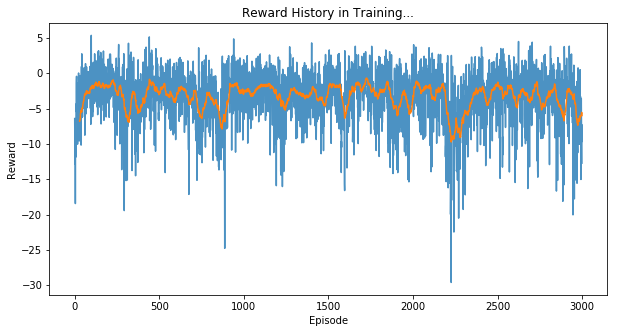

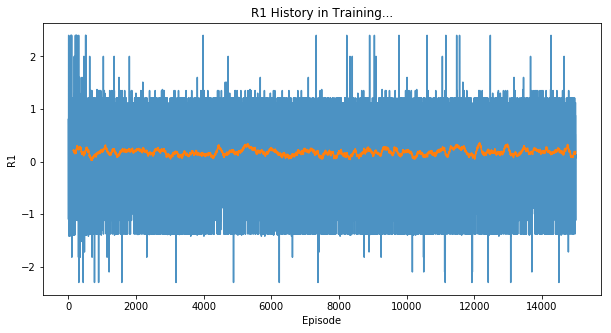

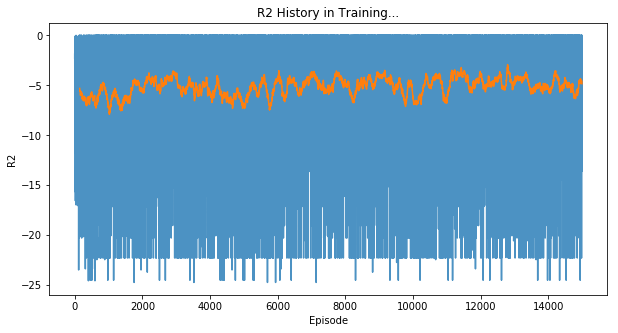

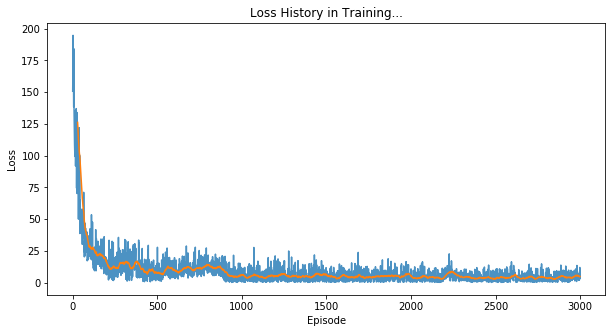

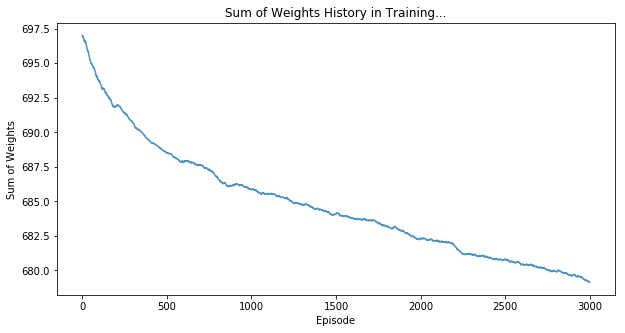

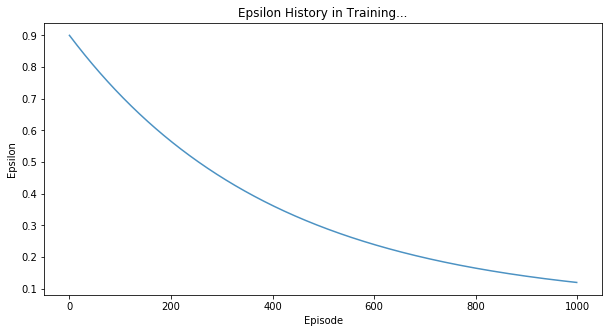

In [755]:
plot_history(reward_history_v3, "Reward", ma=True)
plot_history(r1s_v3, "R1", ma=True)
plot_history(r2s_v3, "R2", ma=True)
plot_history(loss_history_v3, "Loss", ma=True)
plot_history(weights_history_v3, "Sum of Weights", ma=False)
plot_history(eps_hist, "Epsilon", ma=False)

## Resulting Performance
After a lot of efforts to build a complete new environment (that could be uploaded to OpenAI Gym), and building a DQN agent to learn it, I had produced anad iterated many versions of this agent and network. Finally, I was able to fix some bugs and find parameter values that would make the network actually decrease its loss function. However, up to this point, I was not able to make the agent learn how to improve its reward. 
This has led me to insert a functionality to calibrate the reward weights which I later used and has helped wonders, match the decay rate of epsilon to the number of episodes, to modify the structure of training, to save all of these parameters' histories as well as to look at the specific sample results, and to inspect the results manually and musically.
The reward function oscilates around a constant value.


It was weird to me that the loss decreases, while the reward does not increase. Naively, I would have expected the agent to exploit higher-rewards.
However, while a lower loss means more accurate predictions of value for the current policy, it does not mean that the policy is *good*. Additionally, the problem might lie in the fact that the reward functions were limited in size, especially when given only 1 harmony note and 12 keys, so it had not much room to explore, and not enough variety in outputs (there are total of 12x12x12 possible combinations in this situation which map to deterministic rewards). 

So the policy might have settled into a pattern which help the neural network estimate values well. But it for some reason doesn't find improvements to that policy. It might be a case where it had found a local maximum policy were small changes decrease it and thus it doesn't change it.

### Resulting Harmonization
The top element at each index (timestep) is the melody note played, and the bottom element is the harmony note to go along with it. Let's look at initial and ending examples

In [609]:
np.array(playbacks[0]).T

array([[ 7,  7,  6,  0,  6,  7,  2,  8, 11,  6,  0,  7,  4,  0,  8,  6],
       [ 1, 10, 10,  6,  7, 10,  5,  0,  0,  3,  4,  2,  8,  4,  5,  0]])

Look at the sequence of harmony notes (second row) along this example.
When we take as an example the first episode, we see that they oscilate quite a lot.
That would be penalized by the negative reward R2 which penalizes for large jumps within a voice.
Let's look at a later training example:

In [610]:
np.array(playbacks[-1]).T

array([[ 9,  9,  3,  7,  8,  3,  9,  4,  4,  6, 10, 10,  6,  1,  4,  4],
       [10,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  4,  6,  6]])

Look at the sequence of harmony notes (second row) along this example.
When we take as an example the last episode, we see that they stay constant much of the time. It does this because it learned that the further you move the note, it leads to penalization.
However, this shows us a concerning example of what the rewards had led to: the weight of the second reward R2, the penalization of movement within each voice (which is there to enforce voice leading, a musical principle specifying that slight or gradual movements are highly desired and that large intervals are extremely undesirable).

So, _be careful what you wish for_. I created the rule for minimizing movement which was exploited, and now the algorithm didn't move its harmony *unless* it the melofy was playing the SAME note and it was practically forced to. 

**Therefore, I will change the weights between my two reward types, R1 and R2, so that R2 would hopefully not dominate or dominate less.**

------------------------------------------
# V2 - Calibrating the Two Rewards, Two Octaves
------------------------------------------
* According to the previous realization that rward R2 is overfitted, I inserted a functionality for controlling the weights for rewards: R1 and R2, and decreased the weight of R2. I will show history of their values. 
From the initial run (not shown here) without changing the weights of the reward parts R1 and R2, we can see that while r1 varies from -1 to +0.75 pretty uniformly, r2 varies from 0 to -5. Therefore, I'll change their weights to match in scales - multiply r2 by 0.2.
* I also show here the version where I have already increased the number of keybaord keys from 12 to 24

In [746]:
# Set Up Environment
env.seed(42)
PIANO_SIZE = 24
N_HARMONY_NOTES = 1 # CHANGED TO 3 HARMONY NOTES
STEPS = 16
env = MusicEnvLight(piano_size=PIANO_SIZE, 
                    n_harmony_notes = N_HARMONY_NOTES, 
                    max_time_steps = STEPS, bad_jump=6)
## CHANGE REWARD PARAMETERS
# reducing the size or r2 reward
env.r2_weight = 0.2
# env.r1_weight = 0.0
print("training with reward weights: r1_weight={}, r2_weight={}".format(env.r2_weight, env.r1_weight))

# Setting HyperParameters
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 400
TARGET_UPDATE = 10
LEARNING_RATE = 0.001

# Initialize DQN Neural Network 
policy_net = DQN()
policy_net.apply(weights_init)

# Set up our loss function as Huber loss
loss_fn = F.smooth_l1_loss 
# Set up optimizer and corresponding scheduler
optimizer = optim.SGD(policy_net.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# training for 1000, since by then epsilon was still decaying. 
EPISODES = 1000
reward_history_v2, loss_history_v2, weights_history_v2, playbacks_v2, r1s, r2s = train_light(EPISODES)
# eps_hist = create_eps_history()
# plot_history(eps_hist, "Epsilon", ma=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

training with reward weights: r1_weight=0.2, r2_weight=1


100%|██████████| 1000/1000 [01:04<00:00, 15.59it/s]


### V2 Performance

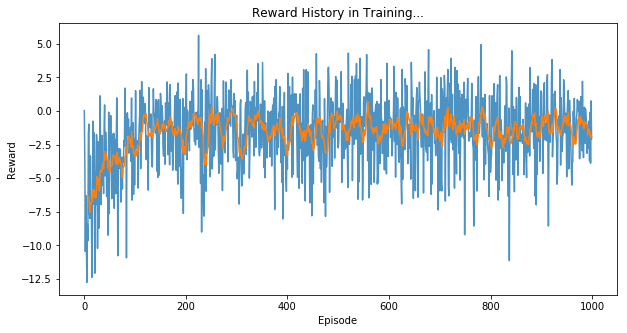

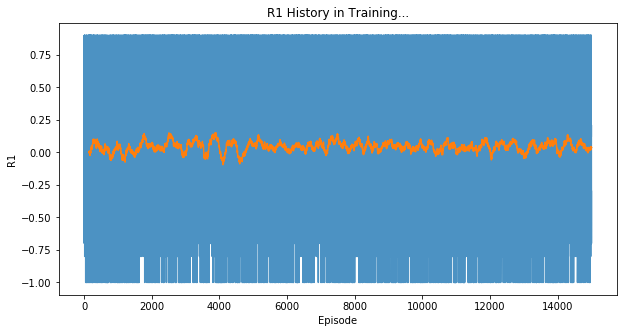

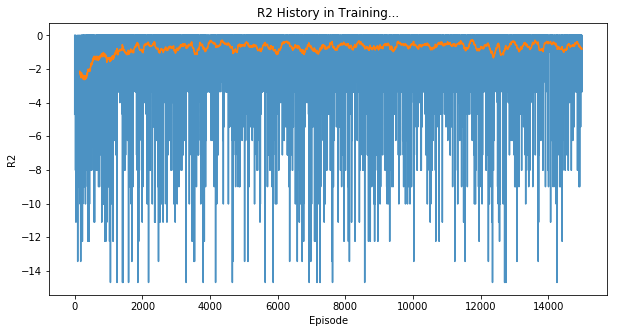

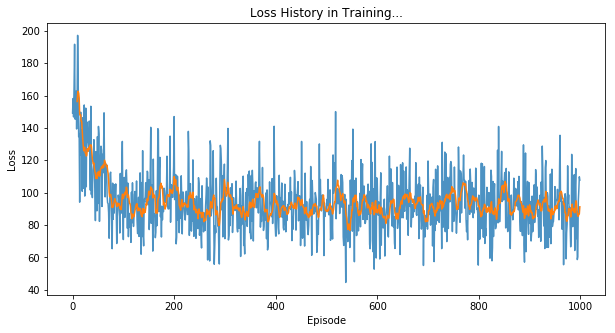

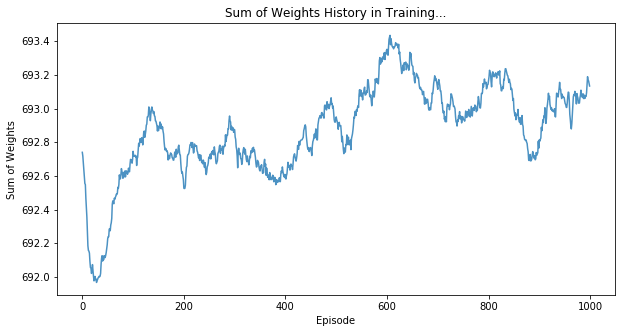

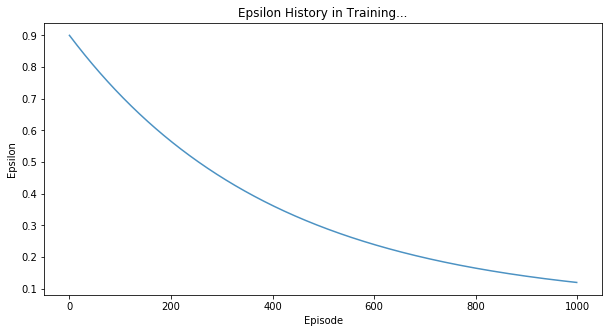

In [732]:
plot_history(reward_history_v2, "Reward", ma=True)
plot_history(r1s_v2, "R1", ma=True)
plot_history(r2s_v2, "R2", ma=True)
plot_history(loss_history_v2, "Loss", ma=True)
plot_history(weights_history_v2, "Sum of Weights", ma=False)
plot_history(eps_hist, "Epsilon", ma=False)

Finally, the performance here is improved - the agent finally learned somehting about the reward! the reward function started to rise, the loss function had decreased too, but not as well. 
This led me to another scrutiny of the code and parameters, callibartion of the reward functions and hyperparameters – and trying out various sizes of the Hidden layer in the DQN. 

# V3 - 3 notes is a charm!
### 3 notes (2 harmony notes), 24 keys, 32 hidden nodes, and modified reward function weighting.
Surprisingly, **modifying the weights between the reward function had a massive impact on the performance of the network.**
I have checked the resulting output musically of the previous networks, and saw that it still was rarely moving, meaning biased towards maximizing r2, which was bad musically. I therefore decreased the weight for r2 further, and behold - the agent was finally able to get through the hurdle of finding a way to maximize the reward through r2 despite almost ignoring r1 (it was alternating minor seconds to stay close, but minor seconds are the most penalized interval in r1), and was able to continue to explore and finally leverage both rewards, as you can see where the averages for r1 and r2 firstly increase (slightly, but increase!).
Keeping all else the same, modifying the weight of r2 from 0.2 to 0.15 already made a huge difference in the resulting reward climb.
Here I present the final version with 2 harmonization notes (total of 3 notes with the given random melody), 24 keys, and 32 hidden nodes (which worked much better than 64!).

In [762]:
# Set Up Environment
env.seed(42)
PIANO_SIZE = 24
N_HARMONY_NOTES = 2 
STEPS = 16
env = MusicEnvLight(piano_size=PIANO_SIZE, 
                    n_harmony_notes = N_HARMONY_NOTES, 
                    max_time_steps = STEPS, bad_jump=6)
## CHANGE REWARD PARAMETERS
# reducing the size or r2 reward
env.r2_weight = 0.15

print("training with reward weights: r1_weight={}, r2_weight={}".format(env.r2_weight, env.r1_weight))

# Setting HyperParameters
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 400
TARGET_UPDATE = 10
LEARNING_RATE = 0.001

# Initialize DQN Neural Network 
policy_net = DQN(hidden=32)
policy_net.apply(weights_init)

# Set up our loss function as Huber loss
loss_fn = F.smooth_l1_loss 
# Set up optimizer and corresponding scheduler
optimizer = optim.SGD(policy_net.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# training for 1000, since by then epsilon was still decaying. 
EPISODES = 1000
reward_history_v3b, loss_history_v3b, weights_history_v3b, playbacks_v3b, r1s_v3b, r2s_v3b = train_light(EPISODES)
# eps_hist = create_eps_history()
# plot_history(eps_hist, "Epsilon", ma=False)

  0%|          | 4/1000 [00:00<00:25, 39.61it/s]

training with reward weights: r1_weight=0.15, r2_weight=1


100%|██████████| 1000/1000 [00:27<00:00, 36.62it/s]


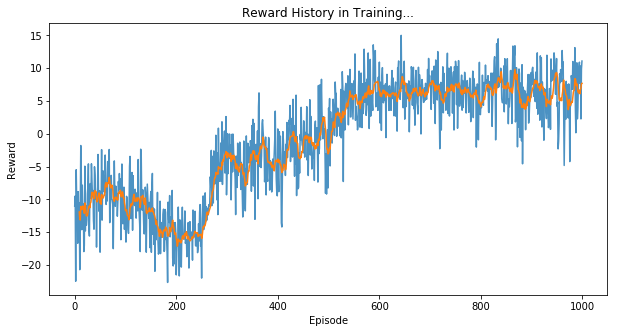

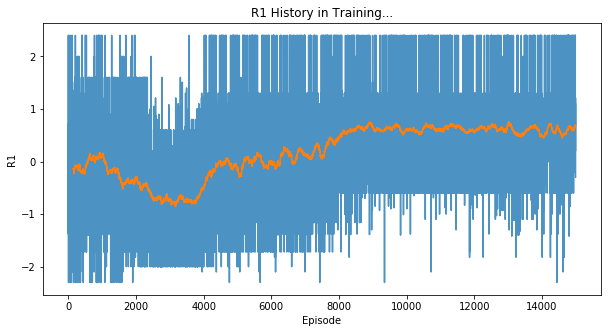

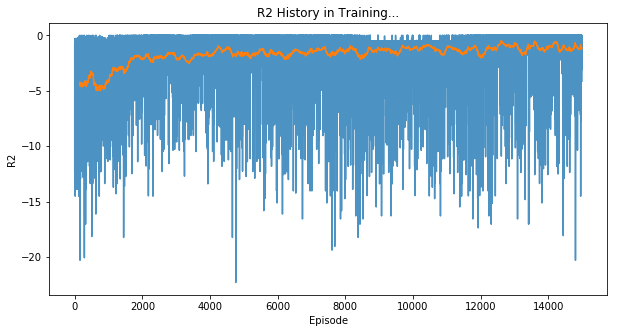

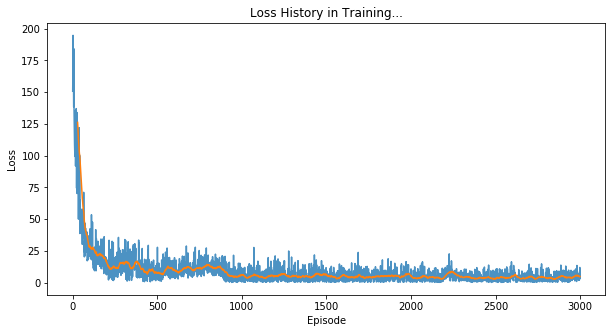

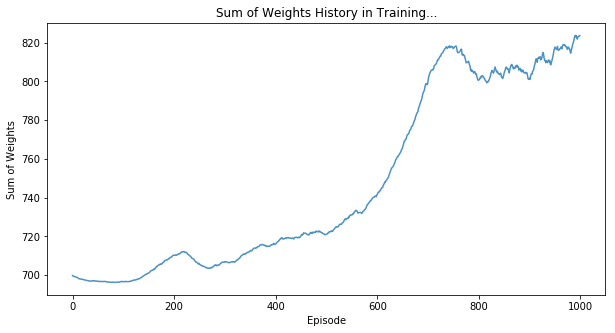

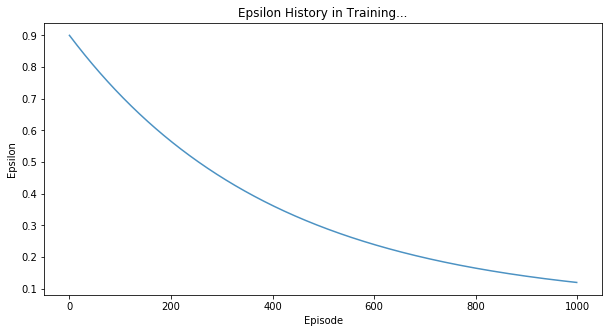

In [767]:
plot_history(reward_history_v3b, "Reward", ma=True)
plot_history(r1s_v3b, "R1", ma=True)
plot_history(r2s_v3b, "R2", ma=True)
plot_history(loss_history_v3b, "Loss", ma=True)
plot_history(weights_history_v3b, "Sum of Weights", ma=False)
plot_history(eps_hist, "Epsilon", ma=False)

**Finally, these patterns are signicantly more successful! We can finally see that the agent *improves* its rewards over time! (although it is still very noisy, but that is inevitable due to the signal it gets). By looking at R1 and R2 seperately, We can see that it is actually improving both of the rewards, even though they are extremely noisy.
The sums of the weights of the network are not oscilating too much or creating alarming patterns, but rather seem to learn over time as they increase and close to the end, fine tuning (although this is just a sum so only a vague proxy for the weights themselves). The espilon decreased at a desirable rate for switching from exploration to exploitation. Finally, the loss function dropped signifincaly and remained very low for the duration of the training.**

# Music Conversion
View resulting harmonizations

In [768]:
# view first iteration (though, random melody)
np.array(playbacks_v3b[0]).T

array([[ 0, 13,  4,  0,  3, 13, 18, 15,  2, 14,  4, 17, 12, 15,  7,  3],
       [22,  1,  6, 21,  9,  2, 11,  2, 14,  5, 18, 16, 20, 19, 12,  3],
       [ 7,  7,  9, 10, 21, 10,  9, 10, 16,  8,  1, 21, 16, 13,  1, 22]])

In [784]:
# view final iteration (though, new random melody)
np.array(playbacks_v3b[1000]).T

array([[ 0,  3, 12, 14, 15, 17, 14,  0,  0, 11, 19, 22,  0,  4, 18, 23],
       [ 8, 18,  5, 21, 14, 14, 21, 14, 18, 12, 14, 21, 14, 18,  9, 21],
       [16, 12, 13, 16, 12, 21, 14, 12, 12,  3, 16, 14, 16, 12, 19, 16]])

After 1000 iterations, we can tell that agent somewhat overfitted reward_1 (interval consonance) and settled for constant intervals which it switched around many times. However, it is still interesting and a useful result.
Let's see how that music looks like.
I'll be using Music21, a very comprehensive music python library developed and still actively maintained by MIT.

In [785]:
!pip install music21

    100% |████████████████████████████████| 18.5MB 706kB/s ta 0:00:011   28% |█████████                       | 5.2MB 1.3MB/s eta 0:00:11
  Running setup.py bdist_wheel for music21 ... done
  Stored in directory: /Users/tomer/Library/Caches/pip/wheels/7b/21/95/d396f231b8095f30aba2a1fbffbc2411fb22eb4e611ddbed57
Successfully built music21


In [808]:
# note: you have to download and install manually "MuseScore" to convert to music scores

  Could not find a version that satisfies the requirement musescore (from versions: )
No matching distribution found for musescore


In [872]:
from music21 import *

### Tranlsating numerical representation to musical representation

In [849]:
playback = np.array(playbacks_v3b[2000]).T
playback # show melody as an example of input type

array([[ 0, 13,  5, 21,  5,  3, 18, 18,  5, 20, 13,  6, 11, 16, 22,  8],
       [ 8, 18, 12, 18, 12, 18, 12, 21, 12, 12, 21, 12, 18, 12, 12, 21],
       [22, 12, 18, 12, 16, 12, 18, 12, 14, 18, 12, 18, 12, 18, 21, 12]])

In [852]:
playbacks_sample = [playbacks_v3b[5000].T,playbacks_v3b[1100],playbacks_v3b[1500], playbacks_v3b[800], playbacks_v3b[2000] ]

In [888]:
playbacks_sample = []
for i in [0,1000,1600,1800,2000,3000,4000,5000,10000,12000,13000,14000]:
    playbacks_sample.append(np.array(playbacks_v3b[i]).T)


Score  0


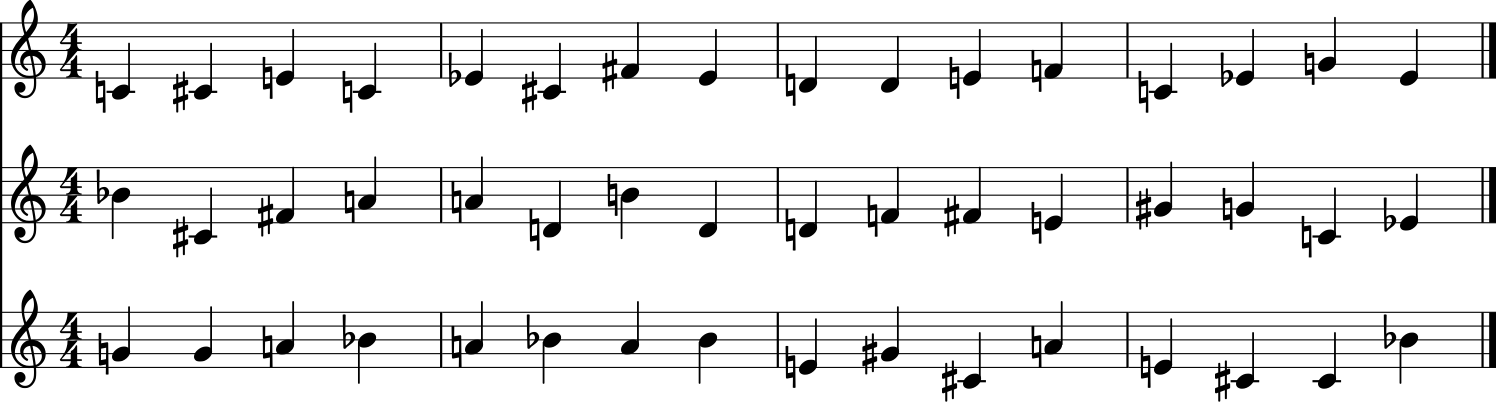


Score  1


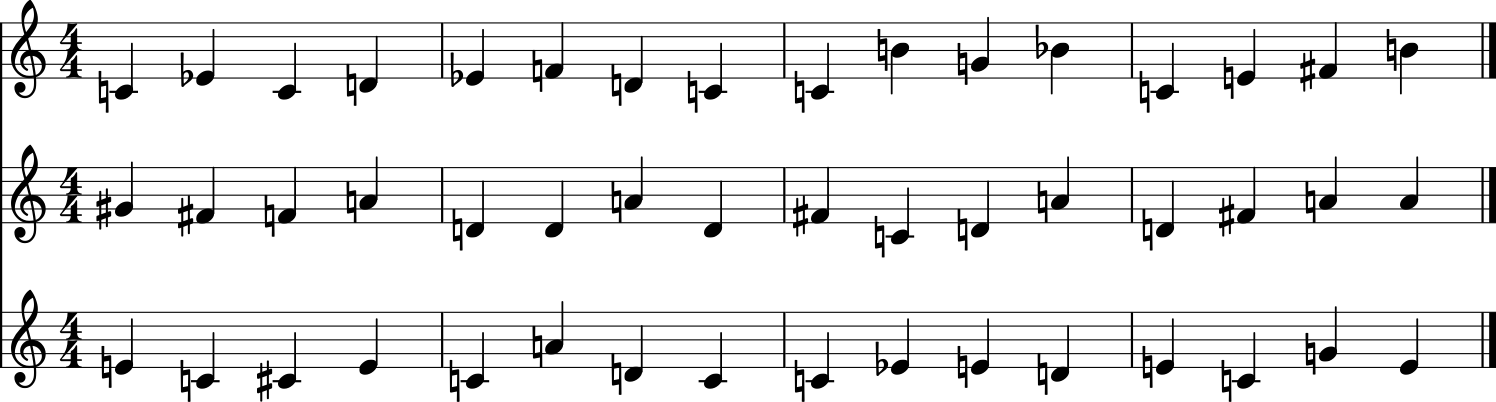


Score  2


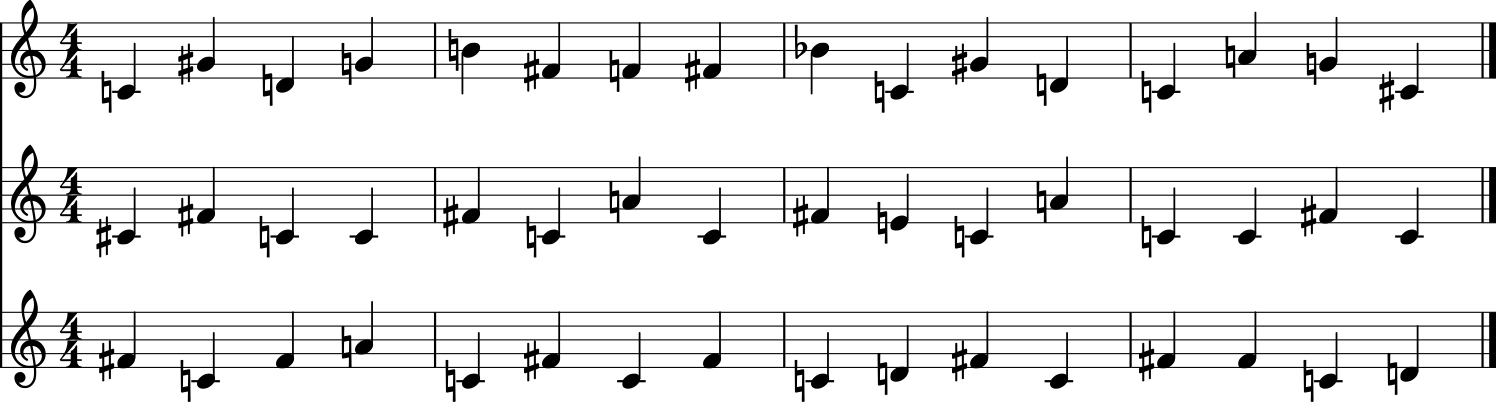


Score  3


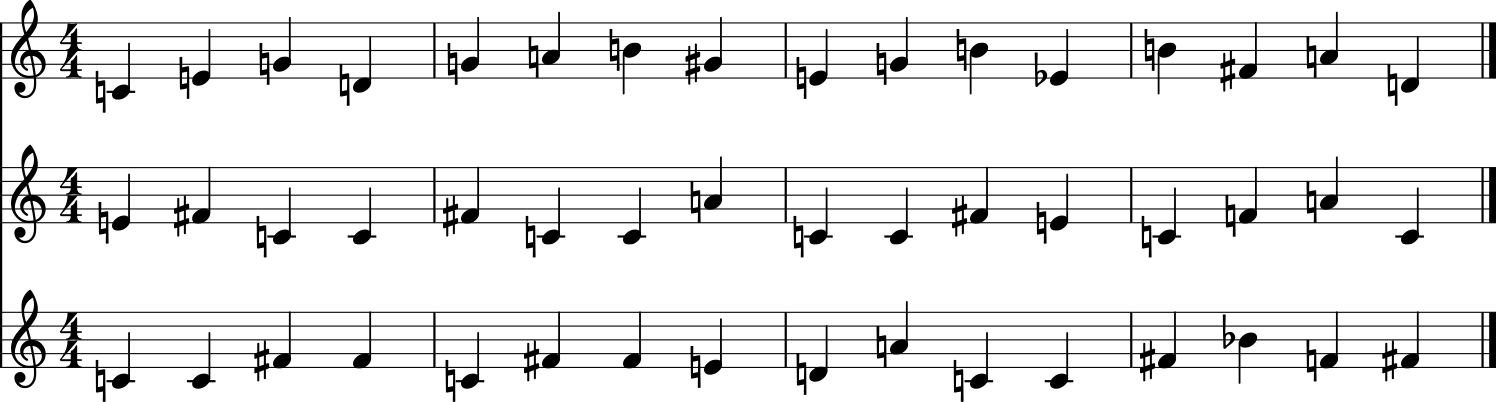


Score  4


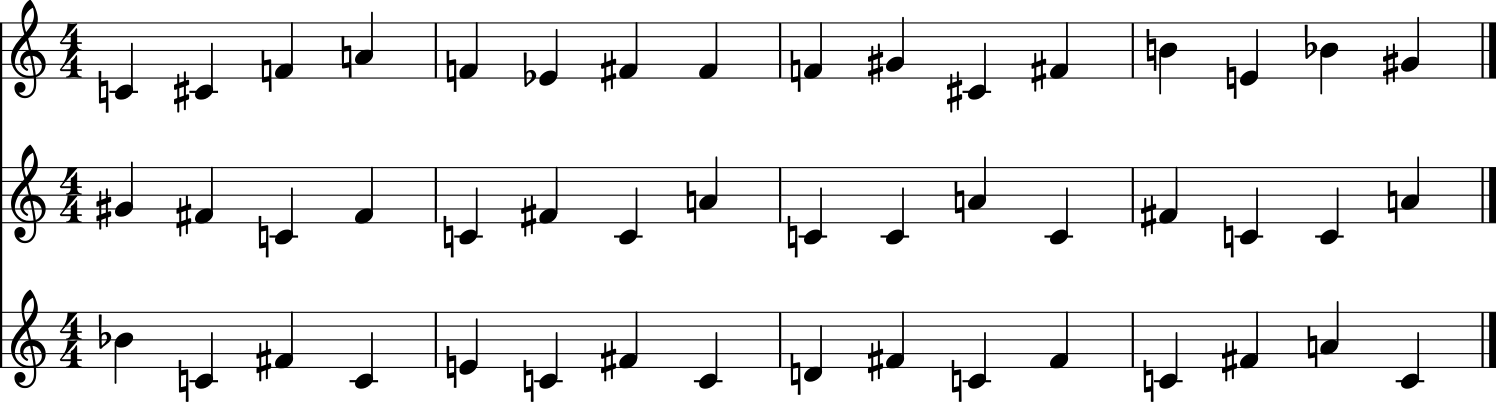


Score  5


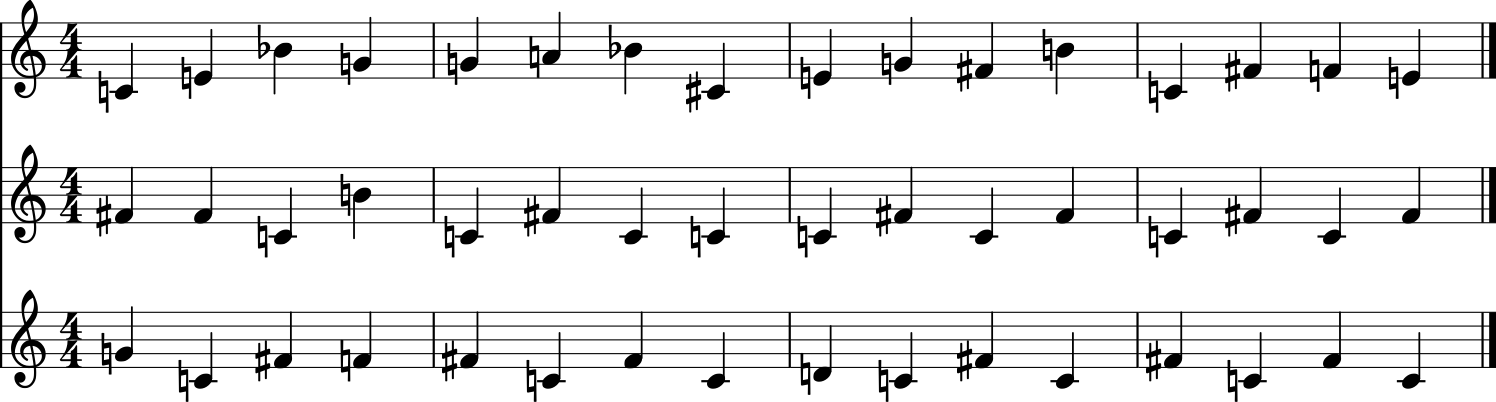


Score  6


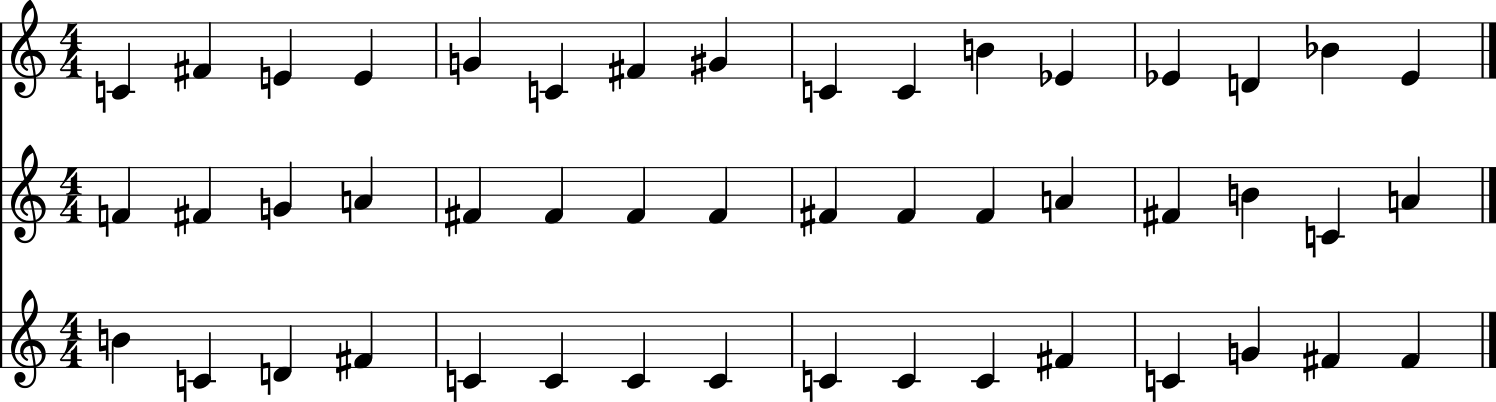


Score  7


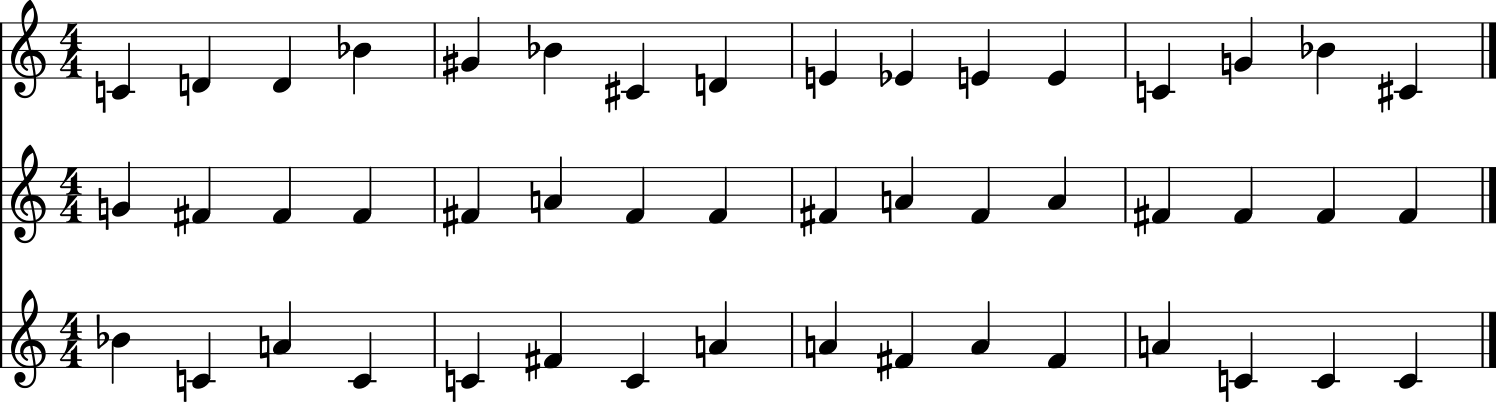


Score  8


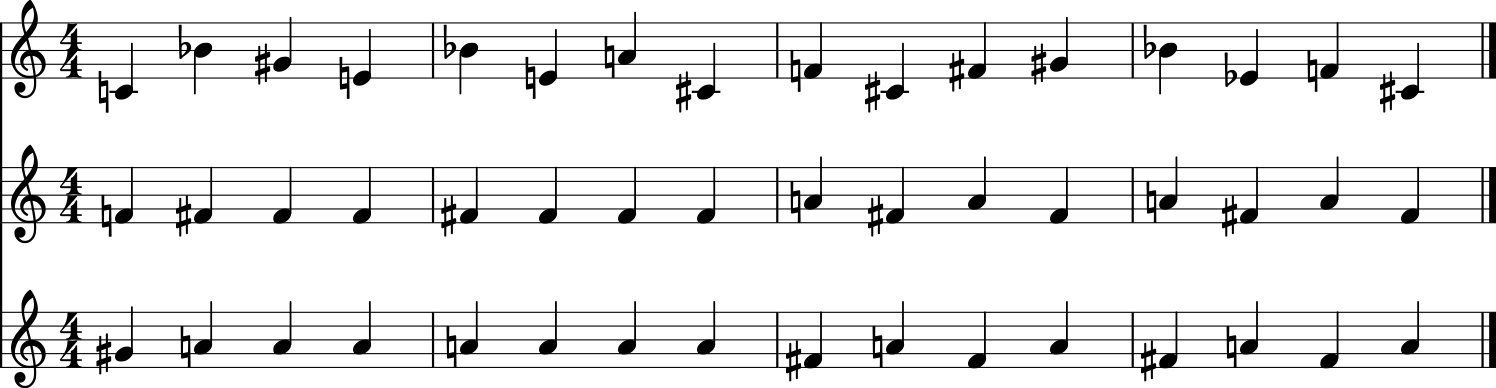


Score  9


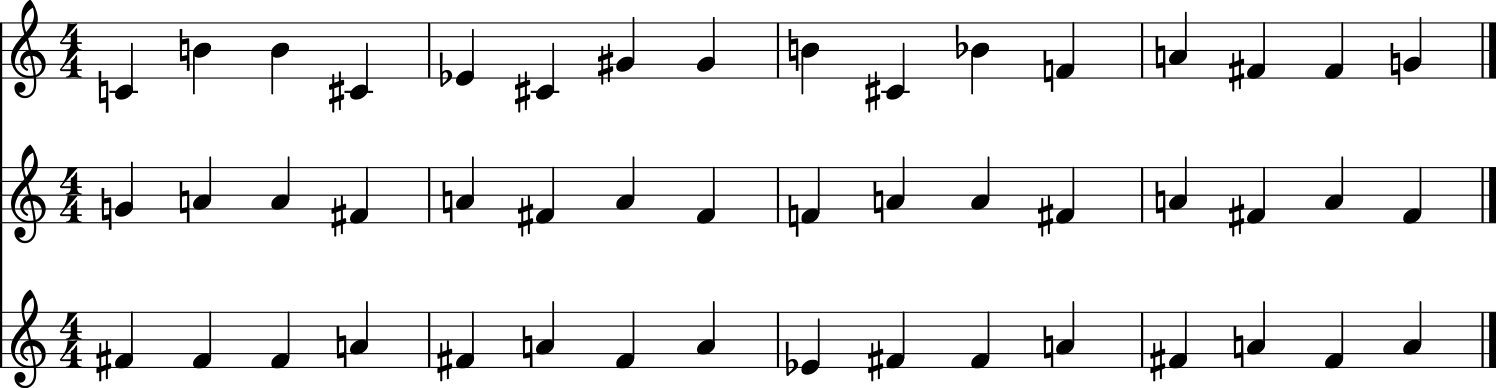


Score  10


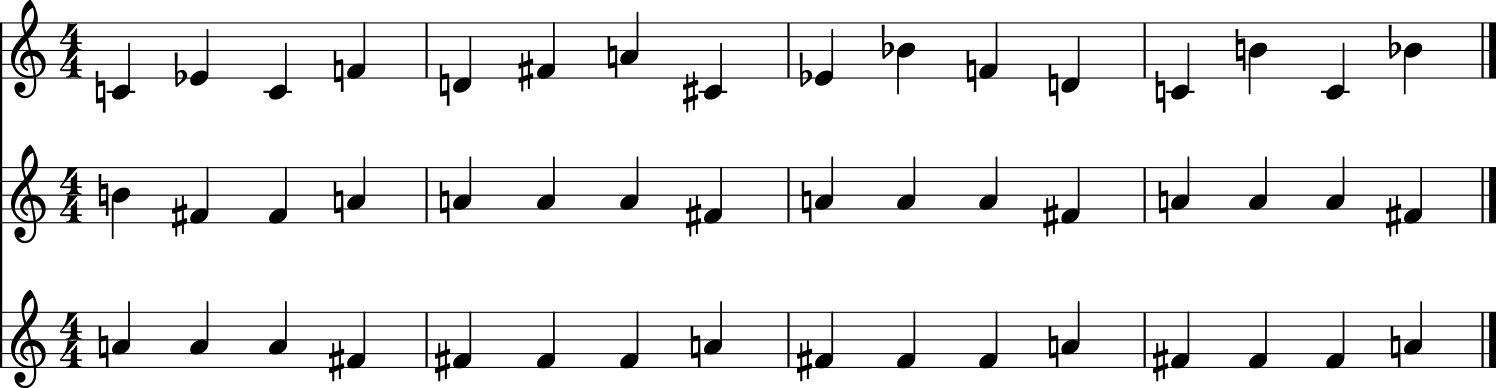


Score  11


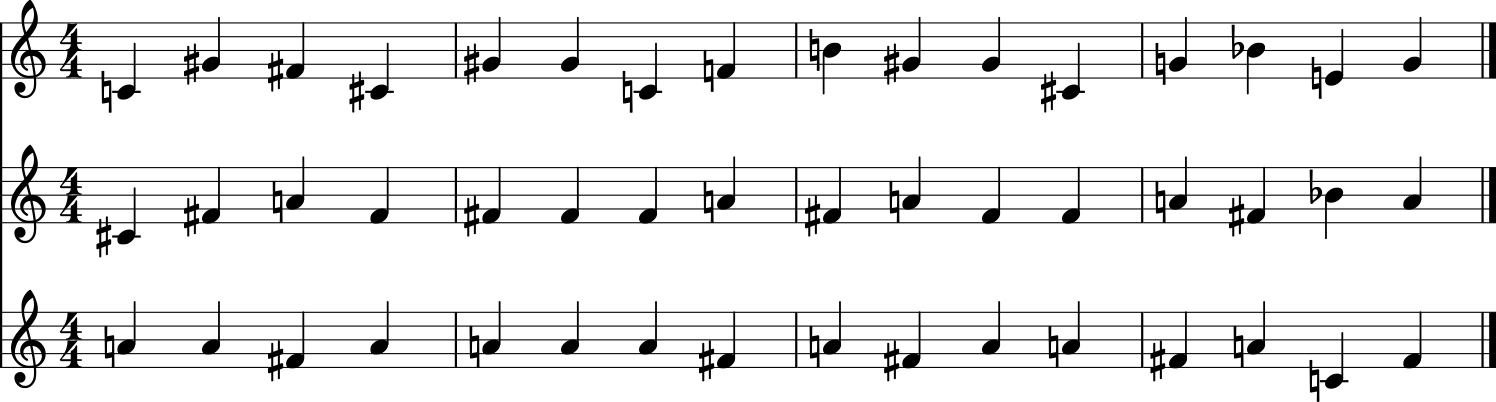

In [889]:
# building a translator between numbers to musical representation for music 21

def convert_part(melody, part):
    for pitch_int in melody:
        n = note.Note()
        n.pitch.pitchClassString = pitch_int
        part.append(n)

def create_score(playback):        
    sc = stream.Score() # create full score canvas
    sc.keySignature = key.KeySignature(0)
    p1 = stream.Part() # create part 1
    p2 = stream.Part() # create part 1
    p3 = stream.Part() # create part 1
    p1.id = 'Melody'
    p2.id = 'Part 2'
    p3.id = 'Part 3'
    # p1.id = 'part1' 
    # create p1,p2,p3 parts from the computer generated playback
    convert_part(playback[0], p1)
    convert_part(playback[1], p2)
    convert_part(playback[2], p3)
    # analyzed key
    analyzedKey = p1.analyze('key')
    sc.insert(0, p1)
    sc.insert(0, p2)
    sc.insert(0, p3)
    sc.show()
    return sc

scores = []
for playback_i in range(len(playbacks_sample)):
    print("\nScore ", playback_i)
    scores.append(create_score(playbacks_sample[playback_i]))    

You can hear the progression of the algorithm's musical output for yourself by converting this to MIDI!

In [890]:
for score in scores:
    score.show('midi')
# this plays midi files. You probably can't hear it from viewing this static version of the notebook.

I thought the most interesting use case was score 9. I will show it again:

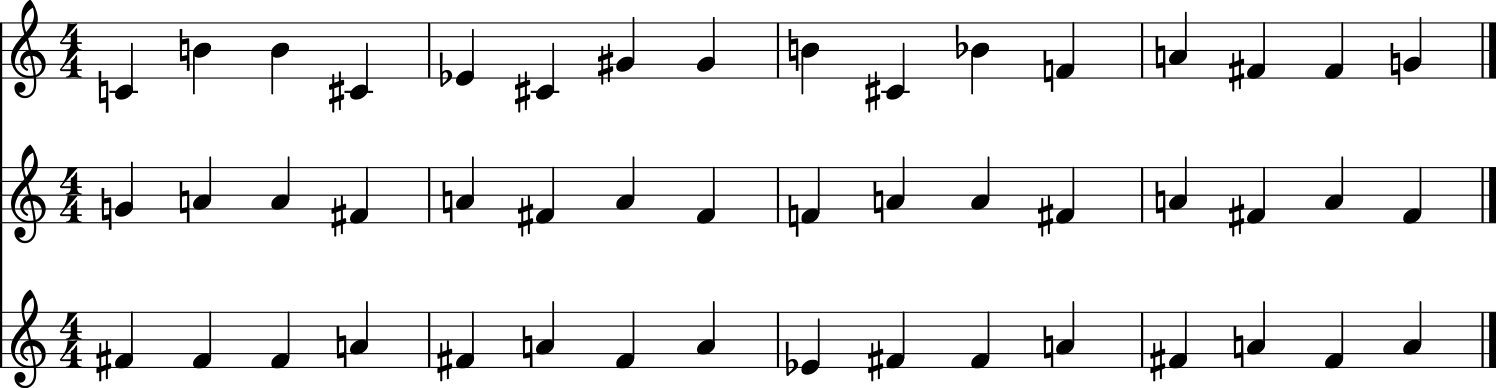

In [891]:
score = scores[9]
score.show()

**The algorithm here basically decided to stick most of the time with *the same underlying harmony (F# minor)*, while constantly changing notes and not repeating notes in a single voice almost ever. This creates consistency. The final note is out of key, but that comes from the randomly generated melody, while the harmony stayes the same.**

In [ ]:
# write to midi file offline
fp = score.write('midi', fp='midi_sample_RL.midi')

# Conclusions

### Music RL Environment
This project has implemented firstly a dedicated reinforcement learning environment to music, specifically for the task of music harmonization, as an OpenAI Gym Environment, and I intend to work on it more and upload it to OpenAI environment. The strength of this envrionment is that is an extremely simplistic numberical representation of notes to experiment with harmonization or melody, it is dynamic and able to randomize melodies in real-time (thus not needing any data input), and is flexible for various sizes of "keybaords" or number of harmony voices. The reward functions, rules and quantifications could also be easily changed. The drawbacks of this envrionment is that it doesn't have rythms, it does not learn any "chord" relations, and it is very limited to a specific musical context and set of tasks.


### RL Agent with DQN 
This project had built a reifncorment learning agent that learns to harmonize to a given melody (even random). I use the DQN algorithm to achieve this, which learns to esimate the Q function using a deep neural network, which I have built from scratch for this purpose and experimented with various forms of it [1]. This agent is custom tailored to this music envrionment. It had required many days of careful planning anad building, debugging and improving, changing hyperparameters, redefining steps, selection of actions, changing reward functions, inserting inner modarity (callibarating rewards), slowly scaling it to more harmony notes and more piano keys, while always trying to improve the performance of the agent.
By the end, I have managed to not only build a functional agent that functions in this environment and could scale to larger keyboard sizes and harmony notes, but it had been succesfull at *learning* it, improving both its loss function and its reward given.
I have converted some example results over course of training the model to musical representations (musical notations and MIDI sound bites), and it sounds like the agent was improving according to the reward functions I have defined – but that these reward funcitons are slighlty misleading and are not the best representation of all that is good about music. The agent seemed to overfit to some of the rewards while surprising with others (staying on the same harmony while switching between the voices).

# Future Work
Most urgently, the reward functions should be iterated upon to create a more realistic (and continuous) representation of musical rewards, if we wish to present more musical outputs. I would later try to scale the model to more harmony notes and check that the performance is reasonable, and that the agent doesn't overfit to some rewards while ignoring others. I would want to change the structure of the input to a given fixed input melody, so that (a) the agent will try harmonizing the same melody multiple times and learn from knowing what fits better a given meldoy (for example, 100 attemps per melody), and that (b) I would insert known and real melodies rather than randomly generated ones.
Next, it would be great to try various deep reinforcement learning algorithms which might stabilize and improve perforance (as rewards, loss and performance were all very noisy) – such as Fixed Q targets, Double DQN, Dueling DQN, or even Policy-based methods, which might in fact work well in this case of abstract music to explore the creative space (rather than maximize a deterministic reward).


**[1] #LO: DeepLearningFundementals – please grade on THIS LO, since I have used and implemented deep learning fundementals from scratch for my independtally defined project.**

